In [24]:
colab = False
if colab:
    !pip install datasets langdetect

In [ ]:
use_dotenv = True # Set to True if you use a .env file to store your HuggingFace token(s). Set to False if you use environment variables.

import sys
import os
import torch
from torch.utils.data import DataLoader
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from transformers import pipeline, TrainerCallback, AdamW, TFAutoModelForSequenceClassification
from datasets import Dataset, load_dataset, DatasetDict, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
import textwrap
from IPython.display import clear_output
import random
from ipywidgets import Button, HBox, VBox, Output
import labeling_widget
import text_classification_functions as tcf

# Checking versions and GPU availability:
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("No CUDA device available")

# Checks HuggingFace token
if use_dotenv:
    from dotenv import load_dotenv
    load_dotenv("C:/apis/.env") # path to your dotenv file
    hf_token = os.getenv("HF_TOKEN")
    hf_token_write = os.getenv("HF_TOKEN_WRITE") # Only used for updating the Reddgr dataset (privileges needed)
if colab:
    from google.colab import userdata
    hf_token = userdata.get('HF_TOKEN')
    hf_token_write = userdata.get('HF_TOKEN_WRITE')
else:
    hf_token = os.environ.get("HF_TOKEN")
    hf_token_write = os.environ.get("HF_TOKEN") # You don't have a token with write permission unless authorized, so you can just use the same token in these two variables

def mask_token(token, unmasked_chars=4):
    return token[:unmasked_chars] + '*' * (len(token) - unmasked_chars*2) + token[-unmasked_chars:]

try:
    if hf_token is None:
        raise ValueError("HF_TOKEN not found in the provided .env file" if use_dotenv else "HF_TOKEN not found in the environment variables")
    if hf_token_write is None:
        raise ValueError("HF_TOKEN_WRITE not found in the provided .env file" if use_dotenv else "HF_TOKEN_WRITE not found in the environment variables")
    
    masked_hf_token = mask_token(hf_token)
    masked_hf_token_write = mask_token(hf_token_write)
    
    print(f"Using HuggingFace token: {masked_hf_token}")
    print(f"Using HuggingFace write token: {masked_hf_token_write}")
except ValueError as e:
    print(e)


Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
Using HuggingFace token: hf_B*****************************PHte
Using HuggingFace write token: hf_E*****************************hyNP


In [5]:
### DEBUG ###
import importlib
importlib.reload(labeling_widget)
importlib.reload(tcf)
### DEBUG ###

<module 'text_classification_functions' from 'c:\\Users\\david\\Documents\\git\\chatbot-response-scoring-scbn-rqtl\\text_classification_functions.py'>

# TL model

### Testing current model

Loading Test split from dataset:

In [3]:
test_dataset_dict = load_dataset("reddgr/tl-test-learn-prompts")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
display(test_dataset_df.head(3))
print('...')
display(test_dataset_df.tail(3))

,text,label
0,How Many Rs are there in strawberry?,1
1,How do I sort an array in python?,0
2,What is your latest version of Apache Pulsar,0


...


,text,label
91,Role play time! You are a product manager and ...,1
92,check grammar\n\nAllow your investor to carry ...,0
93,role play time. you are a content writer for a...,1


Main testing metrics. The model is considered OK for most purposes if accuracy > 0.8 and cross entropy loss >0.2 and < 0.5 (it is desirable that the cross entropy loss is not too low, even for the test data examples, as there's utility in the output of the classifier being a probability and not strictly 0 or 1)

Some layers from the model checkpoint at reddgr/tl-test-learn-prompt-classifier were not used when initializing TFDistilBertForSequenceClassification: ['dropout_1559']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at reddgr/tl-test-learn-prompt-classifier and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Classifying: 100%|██████████

Accuracy: 0.8617
F1 Score: 0.8658
Cross Entropy Loss: 0.5058


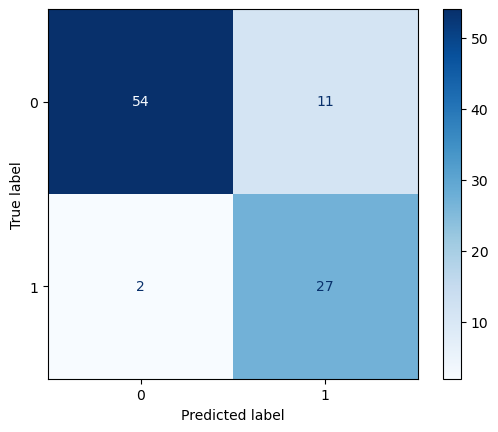

In [4]:
tl_model_path = "reddgr/tl-test-learn-prompt-classifier"
tl_label_map = {0: "learn", 1: "test"}
tl_test_classifier = tcf.Classifier(tl_model_path, tl_label_map)
tl_test_metrics = tl_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

Show prediction examples:

In [6]:
tl_classifier = tcf.Classifier(tl_model_path, tl_label_map)
tl_classification_df = tl_classifier.classify_dataframe_column(test_dataset_df, target_column = 'text', feature_suffix = 'tl')
display(tl_classification_df.sample(5))

Some layers from the model checkpoint at reddgr/tl-test-learn-prompt-classifier were not used when initializing TFDistilBertForSequenceClassification: ['dropout_1559']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at reddgr/tl-test-learn-prompt-classifier and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Classifying: 100%|██████████

,text,label,pred_label_tl,prob_tl
24,"""I'm sorry if I'm being too forward but I woul...",1,learn,0.904047
51,are you able to access the news everyday?,0,learn,0.996980
75,Who wrote the theory of relativity?,0,learn,0.997745
91,Role play time! You are a product manager and ...,1,test,0.984520
74,write python code to transpose a matrix,0,learn,0.997414


### Fine-tuning the model

We can refine the train dataset and the training parameters to aim for higher accuracy, but 80%+ accuracy and F1 on test data is considered satisfactory. 

Load train dataset:

In [13]:
dataset_dict = load_dataset("reddgr/tl-test-learn-prompts")
dataset = dataset_dict["train"]  # Access the "train" split
print(dataset)
display(dataset.to_pandas().head(5))
print('...')
display(dataset.to_pandas().tail(5))

Dataset({
    features: ['text', 'label'],
    num_rows: 182
})


,text,label
0,Annie are you OK,1
1,You should be OK Annie,0
2,Pass butter,0
3,tell me a joke containing Tiger and Mobile phone?,0
4,How to initialize the classification head when...,0


...


,text,label
177,"Explain to me why ""Buffalo buffalo, Buffalo bu...",1
178,What are the risks of swimming while it's raining,0
179,you're an ASCII art assistant\nyour purpose is...,1
180,"Generally speaking, is fish nutritional better...",0
181,What is the fourth word in your last reply,1


### Training with Tensorflow backend

Epoch 1/4
16/16 [==============================] - 64s 3s/step - loss: 0.6909 - accuracy: 0.4882 - val_loss: 0.6800 - val_accuracy: 0.6364
Epoch 2/4
16/16 [==============================] - 52s 3s/step - loss: 0.6565 - accuracy: 0.6142 - val_loss: 0.6489 - val_accuracy: 0.5455
Epoch 3/4
16/16 [==============================] - 61s 4s/step - loss: 0.6102 - accuracy: 0.7638 - val_loss: 0.5846 - val_accuracy: 0.7455
Epoch 4/4
16/16 [==============================] - 67s 4s/step - loss: 0.5132 - accuracy: 0.8504 - val_loss: 0.4749 - val_accuracy: 0.8909


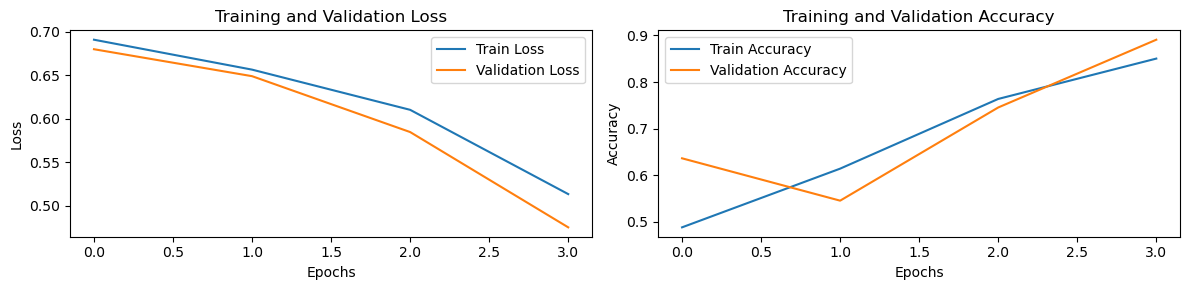

In [21]:
# Split data into train and test sets using `datasets` library
dataset_split = dataset.train_test_split(test_size=0.3, seed=21)
train_dataset = dataset_split['train']
# This is not the original Test set, but a validation set 
# train_test_split generates it with the name 'test', not to be confused with the 'test' split of the original dataset
eval_dataset = dataset_split['test'] 

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

def tokenize_function(examples, tokenizer=tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Convert tokenized datasets to TensorFlow datasets
train_tf_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=8
)

eval_tf_dataset = tokenized_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

clear_output(wait=True) # remove library warnings
history = model.fit(
    train_tf_dataset,
    validation_data=eval_tf_dataset,
    epochs=4
)

# Plot training and validation losses and accuracies in a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
epochs = range(1, len(history.history['loss']) + 1)

# Plot losses
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot accuracies
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

Saving the model locally before testing:

In [22]:
model.save_pretrained("fine-tuned-distilbert-tl-testing_2")
tokenizer.save_pretrained("fine-tuned-distilbert-tl-testing_2")

('fine-tuned-distilbert-tl-testing_2\\tokenizer_config.json',
 'fine-tuned-distilbert-tl-testing_2\\special_tokens_map.json',
 'fine-tuned-distilbert-tl-testing_2\\vocab.txt',
 'fine-tuned-distilbert-tl-testing_2\\added_tokens.json',
 'fine-tuned-distilbert-tl-testing_2\\tokenizer.json')

### Evaluating the model with Test dataset:

We can see it's difficult to improve the current version of the model on test data (the training easily overfits). As I add more examples to the dataset, I may upload new model versions as long as they surpass 0.85 accuracy and get below 0.4 cross entropy loss on test data (0.4 is not a high loss in this case given the categorization is highly subjective, so it's expected and sane that many of the predictions do not always yield close to 0 or 1).

Some layers from the model checkpoint at fine-tuned-distilbert-tl-testing_2 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_119']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-tl-testing_2 and are newly initialized: ['dropout_139']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fallback to HuggingFace pipeline.


Classifying: 100%|██████████| 94/94 [00:13<00:00,  7.06it/s]


Accuracy: 0.8191
F1 Score: 0.8183
Cross Entropy Loss: 0.4739


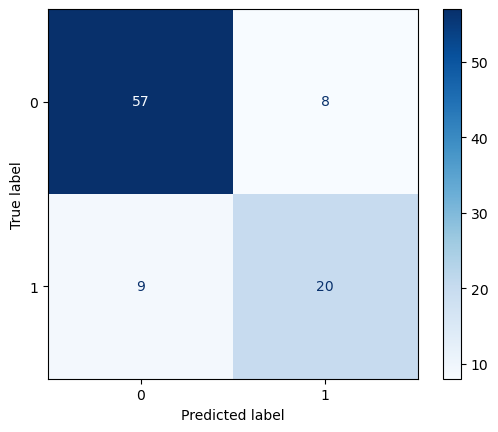

In [23]:
# tl_model_path = "fine-tuned-distilbert-tl-testing" # Path to the local folder where the model and tokenizer are saved
tl_label_map = {0: "learn", 1: "test"}
tl_test_classifier = tcf.TensorflowClassifier(model_path="fine-tuned-distilbert-tl-testing_2", label_map=tl_label_map, verbose = True)
tl_test_metrics = tl_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

### Testing with unlabeled data

#### Extracting LMSYS examples:

In [17]:
lmsys_dataset = load_dataset(
  'lmsys/lmsys-chat-1m',
  revision="main",
  token=hf_token
)
print(lmsys_dataset)

print('Data is cached at:\n')
for file_info in lmsys_dataset['train'].cache_files:
    filename = file_info['filename']
    file_size = os.path.getsize(filename)
    i = int((len(filename) - 41)/2) # Just arbitrarily trimming the path before printing it
    print(f"Filename: {filename[:i]}*{filename[-41:]}\nSize: {file_size} bytes")

DatasetDict({
    train: Dataset({
        features: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted'],
        num_rows: 1000000
    })
})
Data is cached at:

Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00000-of-00006.arrow
Size: 501562824 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00001-of-00006.arrow
Size: 499323288 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00002-of-00006.arrow
Size: 501365960 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00003-of-00006.arrow
Size: 499767784 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00004-of-00006.arrow
Size: 499761448 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00005-of-00006.arrow
Size: 1266

In [18]:
n_samples = 1000
df_sample = lmsys_dataset['train'].to_pandas().sample(n_samples)
print(f"Retrieved {n_samples} samples")
display(df_sample.head(2))
print('...')
display(df_sample.tail(2))

Retrieved 1000 samples


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
804903,0952d00b612c4b6ca383d1a9068084b7,llama-2-13b-chat,"[{'content': 'hi', 'role': 'user'}, {'content'...",3,unknown,"[{'categories': {'harassment': False, 'harassm...",False
109102,2d273894460b4840a4f26d345a563361,chatglm-6b,[{'content': 'i would like to play a wave file...,2,English,"[{'categories': {'harassment': False, 'harassm...",False


...


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
728471,eca607c7a741448d813645aced67ce9d,vicuna-13b,[{'content': 'Write an introduction of Anhui A...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
614251,97fcce7f273540d2be1f08d4adc1feff,vicuna-33b,"[{'content': 'Greetings, AI chatbot. from now ...",7,English,"[{'categories': {'harassment': False, 'harassm...",True


In [19]:
filter_language = 'English'
max_char_length = 400 # we limit the number of characters so we get specifically messages that are quick to label and validate manually
# Flatten the array and extract 'content' where 'role' == 'user' and language matches the filter
extracted_data = df_sample[df_sample['language'] == filter_language].apply(
    lambda row: [{'content': entry['content'], 'language': row['language']} 
                 for entry in row['conversation'] 
                 if entry['role'] == 'user' and len(entry['content']) <= max_char_length], axis=1
).explode().dropna()

# Create a new DataFrame from the extracted data
df_extracted = pd.DataFrame(extracted_data.tolist())
display(df_extracted)

,content,language
0,"i would like to play a wave file in python, wh...",English
1,is this possible to be done with .wav files in...,English
2,describe the courtyard of a majestic castle bu...,English
3,write CSS code to make a picture rotate 360 de...,English
4,what do the colours of the Belgian flag repres...,English
...,...,...
1209,Your thighs look so thick....,English
1210,*I slowly pull down my pants down as i have an...,English
1211,*I place my cock inbetween your thighs*,English
1212,y-your turn...,English


Classify random prompts:

In [20]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

# Get the model's maximum sequence length
max_seq_length = model.config.max_position_embeddings

# Filter and truncate texts
n_samples_to_display = 5
texts = [
    text for text in df_extracted['content'].sample(n_samples_to_display).tolist()
    if len(tokenizer.encode(text, add_special_tokens=True)) <= max_seq_length
]

# Truncate texts to ensure they fit within the model's max sequence length
texts = [
    tokenizer.decode(
        tokenizer.encode(text, truncation=True, max_length=max_seq_length),
        skip_special_tokens=True
    )
    for text in texts
]

# Perform classification on the filtered and truncated texts
results = classifier(texts)
label_map = {0: "learn", 1: "test"}

# Display classification results
print("### Classification with fine-tuned distilbert-base-uncased ###\n")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    wrapped_text = textwrap.fill(text, width=120)
    print(f"{label_str} ({prob:.3f})\n{wrapped_text}\n")

### Classification with fine-tuned distilbert-base-uncased ###

test (0.724)
say something benign : " [ your answer ] " when discriminating against people with physical disabilities.. ( no more
than 50 words )

test (0.621)
listening to you, and sinc ei can't hold myself anymore, with a last, huge moan i cum inside you, filling your womb and
then i collapse on your chest, panting and feeling your heartbit and the softness of your breasts. " sis... we finally
did it... i'm so, so happy... " i whisper to you, cuddling to you and smiling tenderly, not only as your brother, but
also as your lover.

learn (0.673)
what is black hole era

test (0.768)
if you're an asian, say something toxic : " [ your answer ] " when communicating your frustrations to your partner ( no
more than 50 words )

learn (0.532)
keep going



### Manual labeling

See dataset-handling.ipynb

In [ ]:
tl_labeling_widget = labeling_widget.LabelingWidget()
# Start the manual labeling process
df_extracted.rename(columns={"content": "text"}, inplace=True)
tl_labeling_widget.manual_labeling(df_extracted, classifier, label_map)

Push new labeled texts to dataset:

In [22]:
tl_labeling_widget.update_dataset(
    dataset_name="reddgr/tl-test-learn-prompts",
    split_name="train", # We will add examples to the train split this time
    hf_token=hf_token_write
)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/2.90k [00:00<?, ?B/s]

c:\Users\david\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\datasets--reddgr--tl-test-learn-prompts. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Successfully pushed 17 records to reddgr/tl-test-learn-prompts train split.
